# Loading data to produce training data

In [1]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely 
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

## Download country boundaries

In [2]:
ISO = 'SWE' # "DEU" is the ISO code for Germany
ADM = 'ADM2' # Equivalent to administrative districts

# Query geoBoundaries
r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM={}".format(ISO, ADM))
dl_path = r.json()[0]['gjDownloadURL']

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(dl_path).json()
with open(filename, 'w') as file:
    geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (290, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
85,Odeshog kommun,None,SWE-ADM2-3_0_0-B86,SWE,ADM2,"MULTIPOLYGON (((14.84506 58.35859, 14.85365 58..."
116,Kalix kommun,None,SWE-ADM2-3_0_0-B117,SWE,ADM2,"MULTIPOLYGON (((22.97036 65.65576, 22.97032 65..."
268,Laholm kommun,None,SWE-ADM2-3_0_0-B269,SWE,ADM2,"MULTIPOLYGON (((13.39759 56.60885, 13.40426 56..."


In this example, we visualize the adminstrative boundary for district **Sala kommun** using the GeoPandas `.plot()` function.

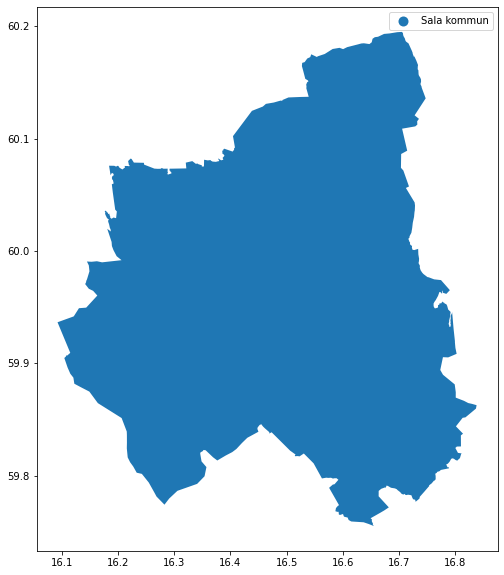

In [3]:
shape_name = 'Sala kommun'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

## Authenticate Google Earth Engine

In [6]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AdQt8qhAuhp19UH1Nv8aLqCd6Pz-NwmCRESjpp4dd_E4m8I7bWpm0IDUkZM



Successfully saved authorization token.


In [7]:
product='COPERNICUS/S1_GRD'
min_date='2018-01-01'
max_date='2020-01-01'
range_min=0
range_max=2000
cloud_pct=10

# Get the shape geometry for Sala kommun
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region)

# sarImage = ee.ImageCollection(product)\
#         .filterBounds(region)\
#         .filterDate(str(min_date), str(max_date))\
#         .median()\
#         .clip(region)

sarImage = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
        .median()\
        .clip(region)

bandNames = sarImage.bandNames()
print(bandNames.getInfo())

sarImage = sarImage.select(['VV'])

percentiles = sarImage.reduceRegion(
    reducer=ee.Reducer.percentile([0, 1, 5, 50, 95, 99, 100]),
    geometry=region,
    scale=20
)

minValue = percentiles.get("VV_p1").getInfo()
maxValue = percentiles.get("VV_p99").getInfo()

print(minValue)
print(maxValue)

Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
# Map.addLayer(sarImage, {})
Map.addLayer(sarImage, {'bands': ['VV'], 'min': minValue, 'max': maxValue}, 'SAR-VV');
Map.addLayerControl()
Map

['VV', 'VH', 'angle']
-20.876427785936432
-7.383371917750414


## Export image to local GDrive

In [8]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.
    
    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of 
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))
        
    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()
    
    return task

In [9]:
sarImage = sarImage.float()

In [10]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(sarImage, shape_name + '_sar_vv_single', region, folder)

Exporting to Sala kommun_sar_vv_single.tif ...


In [23]:
task.status()

{'state': 'COMPLETED',
 'description': 'Sala kommun_sar_vv_single',
 'creation_timestamp_ms': 1659980102425,
 'update_timestamp_ms': 1659980704945,
 'start_timestamp_ms': 1659980109602,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1jX4-3iUNKUNV5BkQOlJ37yLJ4tIkg09j'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 5273.626953125,
 'id': 'RX26LU7KCFYENRD4BGDJA7HJ',
 'name': 'projects/earthengine-legacy/operations/RX26LU7KCFYENRD4BGDJA7HJ'}

## Visualize Sentinel-2A Image

<class 'rasterio.io.DatasetReader'>


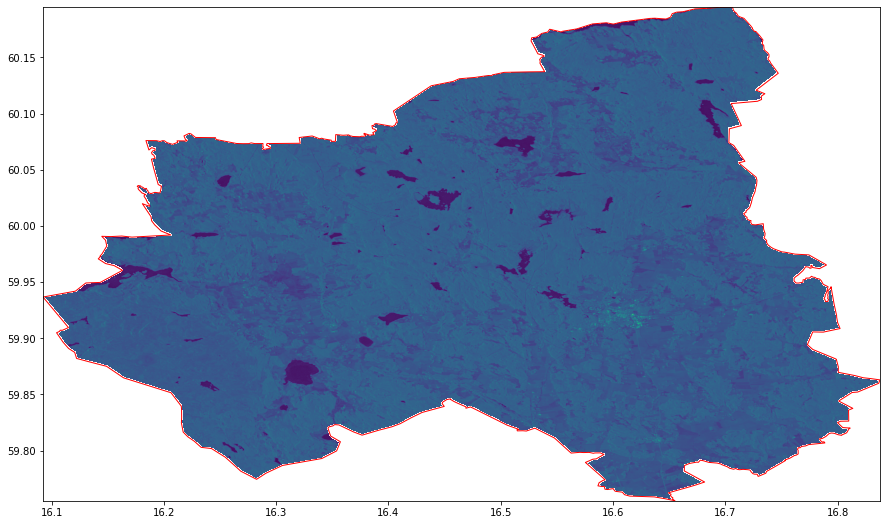

In [115]:
# Change this to your image file path
# tif_file = './drive/My Drive/Colab Notebooks/{}.tif'.format(shape_name) 
# tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}.tif'.format(shape_name) 
# tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}_ndwi_threshold.tif'.format(shape_name) 
# tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}_new_image.tif'.format(shape_name)
# tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}_sar_vv.tif'.format(shape_name) 
tif_file = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/{}_sar_vv_single.tif'.format(shape_name) 

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);
print(type(image))

## Generate 64x64 px GeoJSON Tiles

In [116]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.
    
    Args:
      image_file (str): Image file path (.tif) 
      output_file (str): Output file path (.geojson) 
      area_str (str): Name of the region
      size(int): Window size
    
    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles 
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : [], 'area' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
        for w in range(0, width, size):
            for h in range(0, height, size):
                # Create a Window of your desired size
                window = rio.windows.Window(h, w, size, size)
                # Get the georeferenced window bounds
                bbox = rio.windows.bounds(window, raster.transform)
                # Create a shapely geometry from the bounding box
                bbox = box(*bbox)

                # Create a unique id for each geometry
                uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

                # Update dictionary
                geo_dict['id'].append(uid)
                geo_dict['area'].append(area_str)
                geo_dict['geometry'].append(bbox)

                index += 1
                pbar.update(size*size)
    
    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of size 64x64 px across the Sala kommun Sentinel-2 satellite image.

In [117]:
# cwd = './drive/My Drive/Colab Notebooks/Land Use and Land Cover Classification/'
cwd = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/Land Use and Land Cover Classification'
output_file = cwd+'{}.geojson'.format(shape_name)
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/40630409 [00:00<?, ?it/s]

/Users/frape/miniforge3/envs/deep_wetlands/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (10010, 3)


,id,geometry,area
0,sala_kommun-0,"POLYGON ((16.09808 60.18937, 16.09808 60.19512...",Sala kommun
1,sala_kommun-1,"POLYGON ((16.10383 60.18937, 16.10383 60.19512...",Sala kommun
2,sala_kommun-2,"POLYGON ((16.10958 60.18937, 16.10958 60.19512...",Sala kommun


## Visualize 64x64 px Tiles

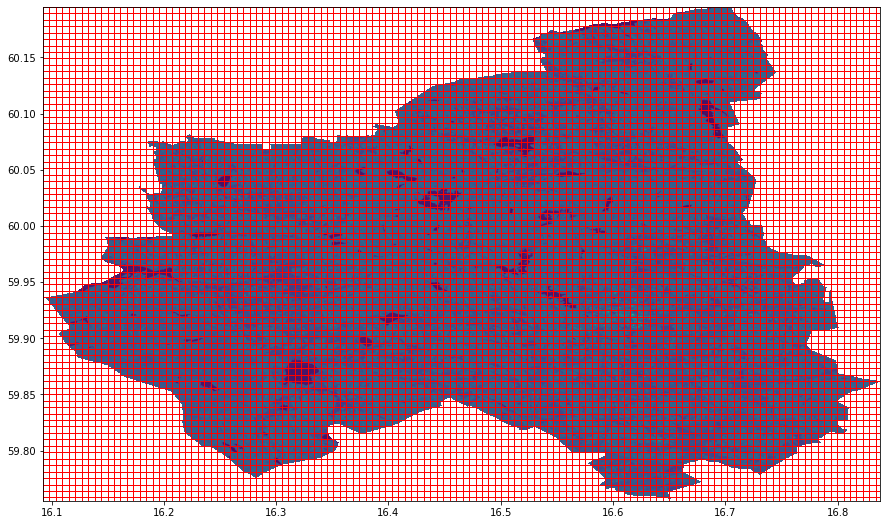

In [118]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Notice that the polygons are generated for empty (black) regions as well. Using our model to predict on blank regions seems computationally wasteful.

Instead, we can get the intersection between: 
- the Kreis Borken boundary polygon and 
- the 64 x 64 grid tiles.

To do this, we use GeoPandas `.sjoin()` function. We set parameter `op='within'` to indicate that we only want the tiles that lie within the district boundary.

[See  more information on GeoPandas sjoin operation here](https://geopandas.org/reference/geopandas.sjoin.html).


/Users/frape/miniforge3/envs/deep_wetlands/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/bk/sld6vd3d79dghhg7k3cxn1v80000gp/T/ipykernel_1192/2778194479.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


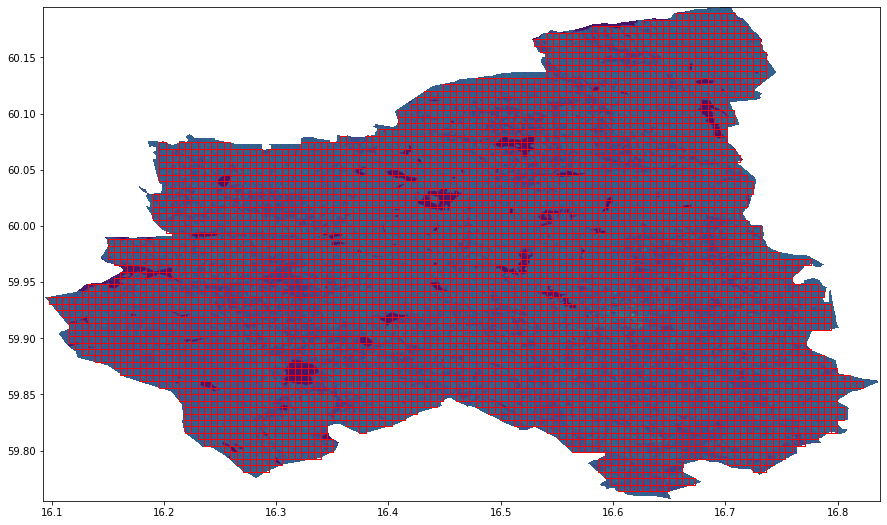

In [119]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualize Single Cropped Image

<class 'rasterio.io.DatasetReader'> <class 'list'>
(1, 65, 65)
(1, 64, 64)
---------------


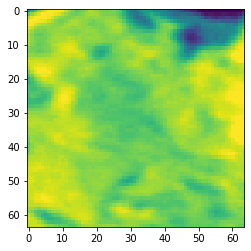

(1, 64, 64) <class 'numpy.ndarray'>
[[[0.5108729  0.63132143 0.70107776 ... 0.00115645 0.0039559  0.06293207]
  [0.74400365 0.8365045  0.8979512  ... 0.07075792 0.0908751  0.209003  ]
  [0.89600354 0.9570354  0.99469393 ... 0.1536446  0.24248615 0.36638185]
  ...
  [0.9423525  0.91921383 0.8731026  ... 0.7858324  0.7965751  0.7845084 ]
  [0.91496515 0.91515    0.9155362  ... 0.79999727 0.79966867 0.79422146]
  [0.8954281  0.91869545 0.92352444 ... 0.7947093  0.7765856  0.75831527]]]
***************************
(4096,)
***************************
(64, 64)
[[130 160 178 ...   0   1  16]
 [189 213 228 ...  18  23  53]
 [228 244 253 ...  39  61  93]
 ...
 [240 234 222 ... 200 203 200]
 [233 233 233 ... 203 203 202]
 [228 234 235 ... 202 198 193]]
<class 'PIL.TiffImagePlugin.TiffImageFile'>
(64, 64)
[[0.5108729  0.63132143 0.70107776 ... 0.00115645 0.0039559  0.06293207]
 [0.74400365 0.8365045  0.8979512  ... 0.07075792 0.0908751  0.209003  ]
 [0.89600354 0.9570354  0.99469393 ... 0.1536446

/var/folders/bk/sld6vd3d79dghhg7k3cxn1v80000gp/T/ipykernel_1192/1239041593.py:51: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  scipy_image = imageio.imread("/tmp/file.png")
/var/folders/bk/sld6vd3d79dghhg7k3cxn1v80000gp/T/ipykernel_1192/1239041593.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(temp_tif)


In [138]:
def show_crop(image, shape, title=''):
    """Crops an image based on the polygon shape.
    Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

    Args:
        image (str): Image file path (.tif) 
        shape (geometry): The tile with which to crop the image
        title(str): Image title
    """
  
    with rio.open(image) as src:
        print(type(src), type(shape))
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        # _, x_nonzero, y_nonzero = np.nonzero(out_image)
        # out_image = out_image[
        #     :,
        #     np.min(x_nonzero):np.max(x_nonzero), 
        #     np.min(y_nonzero):np.max(y_nonzero)
        # ]
        print(out_image.shape)
        if out_image.shape[1] == 65:
            out_image = out_image[:,:-1,:]
        if out_image.shape[2] == 65:
            out_image = out_image[:,:,1:]
        print(out_image.shape)
        
        # Min-max scale the image to the range [0, 1]
        out_image[out_image > maxValue] = maxValue
        out_image[out_image < minValue] = minValue
        out_image = (out_image - minValue)/(maxValue - minValue)
        # Visualize image
        show(out_image, title=title)
        print(out_image.shape, type(out_image))
        print(out_image)
        # img = Image.fromarray(I8)
        img = Image.fromarray(np.uint8(out_image[0] * 255) , 'L')
        img.save("/tmp/file.png")
        
        im_frame = Image.open("/tmp/file.png")
        np_frame = np.array(im_frame.getdata())
        print("***************************")
        print(np_frame.shape)
        
        import imageio
        scipy_image = imageio.imread("/tmp/file.png")
        print("***************************")
        print(scipy_image.shape)
        print(scipy_image)
        
        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })
        
        # Save the cropped image as a temporary TIFF file.
        temp_tif = '/tmp/temp.tif'
        with rasterio.open(temp_tif, "w", **out_meta) as dest:
            dest.write(out_image)
        
        # Open the cropped image and generated prediction  
        # using the trained Pytorch model
        open_image = Image.open(temp_tif)
        
        print(type(open_image))
        im = imageio.imread(temp_tif)
        im_array = np.array(im)
        print(im_array.shape)
        print(im_array)
        
        print((out_image==im_array).all())

show_crop(tif_file, [tiles.iloc[0]['geometry']])

with rasterio.open(tif_file) as src:
    print(src.count)

In [48]:
print(type(tiles), tiles.size)
# print(tiles.head(3))
tiles.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'> 50454


,id,geometry,area,index_right,shapeName,shapeISO,shapeID,shapeGroup,shapeType
228,sala_kommun-228,"POLYGON ((16.66150 60.18362, 16.66150 60.18937...",Sala kommun,28,Sala kommun,None,SWE-ADM2-3_0_0-B29,SWE,ADM2
229,sala_kommun-229,"POLYGON ((16.66725 60.18362, 16.66725 60.18937...",Sala kommun,28,Sala kommun,None,SWE-ADM2-3_0_0-B29,SWE,ADM2
230,sala_kommun-230,"POLYGON ((16.67300 60.18362, 16.67300 60.18937...",Sala kommun,28,Sala kommun,None,SWE-ADM2-3_0_0-B29,SWE,ADM2


In [147]:
def export_sar_data():
    for index in tqdm(range(len(tiles)), total=len(tiles)):

        with rio.open(tif_file) as src:

            shape = [tiles.iloc[index]['geometry']]
            name = tiles.iloc[index]['id']
            # print('id', name)
            # print(type(src), type(shape))
            out_image, out_transform = rio.mask.mask(src, shape, crop=True)
            # Crop out black (zero) border
            # _, x_nonzero, y_nonzero = np.nonzero(out_image)
            # out_image = out_image[
            #     :,
            #     np.min(x_nonzero):np.max(x_nonzero), 
            #     np.min(y_nonzero):np.max(y_nonzero)
            # ]
            if out_image.shape[1] == 65:
                out_image = out_image[:,:-1,:]
            if out_image.shape[2] == 65:
                out_image = out_image[:,:,1:]
            
            # print(out_image.shape)

            # Min-max scale the data to range [0, 1]
            out_image[out_image > maxValue] = maxValue
            out_image[out_image < minValue] = minValue
            out_image = (out_image - minValue)/(maxValue - minValue)

            # Get the metadata of the source image and update it
            # with the width, height, and transform of the cropped image
            out_meta = src.meta
            out_meta.update({
                  "driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform
            })

            # Save the cropped image as a temporary TIFF file.
            temp_tif = '/tmp/sar/{}-sar.tif'.format(name)
            with rasterio.open(temp_tif, "w", **out_meta) as dest:
                dest.write(out_image) 

In [148]:
export_sar_data()
export_data_frame = tiles.copy(deep=True)
export_data_frame = export_data_frame[['id']]
num_rows = len(export_data_frame)
train_rows = int(num_rows * 0.8)
export_data_frame['split'] = 'train'
export_data_frame.iloc[train_rows:, export_data_frame.columns.get_loc('split')] = 'test'
# export_data_frame.iloc[:train_rows, 2] = 'train'
# export_data_frame.iloc[train_rows:, 2] = 'test'

# print(export_data_frame.head())
# print(export_data_frame.head(-10))
export_data_frame.to_csv('/tmp/tiles.csv', columns=['id', 'split'], index_label='index')

  0%|          | 0/5606 [00:00<?, ?it/s]